## Moving Least Squares
Project every point onto a locally fitted smooth surface \
It's not one smooth continuous function. it's many locally smooth functions stitched together. \
Not useful if we want one closed form for the solution \ 
but useful if we are ok with local approximations like in point-cloud processing \
in some cases there just isn't going to be "1 smooth function" that describes the entire surface. \
so in those cases we just have to settle for many locally smooth functions stitched together. 


In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [46]:
np.random.seed(0)
x = np.linspace(0, 2*np.pi, 50) 
f_true = np.sin(x)
f_noisy = f_true + 0.2 * np.random.randn(len(x)) # generated noisy data

Each data point $x_i$ has a radial gaussian weight to it

$ e^{-(x_o - x_i)^2/h^2}$

In [76]:
gaussian_weight(np.array([10,10]),np.array([10,10]),0.1)

array([1., 1.])

In [4]:
# input x0,xi could be floats or arrays. returns floats or array of floats
def gaussian_weight(x0,xi,h):
    d2 = (xi-x0)**2
    return np.exp(-d2/h**2)

assume the solution has a linear form $g(x) = a_0 + a_1(x-x_o)$ where we are expanding around $x_o$. $x$ and $x_o$ are both experimental data points. For each experimental data point we have a model $g^{(i)}(x) = a_0^{(i)} + a_1^{(i)}(x-x_i)$ and it's valid in the locality of $x_i$

the error is $f_i - g(x_i)$ where $(x_i,f_i)$ are the experimental measurements

then we need to minimize the "cost function" 
$J(a_0,a_1) = \Sigma_i w_i[f_i - g(x_i)]^2 $ w.r.t $a_0,a_1$

The $a_0,a_1$ that minimizes $J(a_0,a_1)$ is given by the solution to 
$ \mathbf{A}^T \mathbf{W} \mathbf{A} \vec{a}  = \mathbf{A}^T\mathbf{W}\vec{f}$

where $\mathbf{A} = \begin{bmatrix} 1 & 1 & 1 & ... \\ (x_1 - x_o) & (x_2 - x_o) & (x_3 - x_o) & ... \\ (y_1 - y_o) & (y_2 - y_o) & (y_3 - y_o) & ... \\ ... & ... & ... & ... \end{bmatrix}$ 

we'd use $y-y_o$ if our model solution was $g(x,y)$

where $\mathbf{W} = \begin{bmatrix} w_1 & 0 & 0 \\ 0 & w_2 & 0 \\ 0 & 0 & w_3 \end{bmatrix}$ is a diagonal matrix of all the weights \
and $w_1 = \exp{[-(x_o - x_1)^2/h^2 - (y_o - y_1)^2/h^2]}$  is the gaussian weight for the error in data point $(x_1,y_1)$

for each experimental data point, we are calculating the weight matrix against all the other points
that is x - x0 where x is each point data, and x0 is each point in the data
when x == x0 the weight is 1

For each experimental point $(x_n,y_n)$ we generate a $W$ matrix 
$W^{(n)}_{ij} = \delta_{ij} e^{(-d_{nj}^2/h^2)}$ the distance of the $n^{th}$ experimental point against all the other points $(x_i,y_i)$

$x_n$ is the point that we're expanding around. We evaluate $J(a_0,a_1)$ and minimize it for each $x_n$ 

For the point $x_n$ the Weight matrix has maximum weight for $W_{nn}$ because the experimental data point $f_n$ has most significance in determining the "true" value at the point $x_n$

we take each experiemtnal data point $(x_i,f_i)$ and we nudge the $f_i$ a little $\epsilon_i$ such that the cost functin $J^{(i)}(a_0^{(i)},a_1^{(i)})$ is minimized. we're not replacing each data point with a line but we're moving that point a little. the $a_0^{(i)}$ is the "corrected" value for each experimental data point $f_i$ because the $a_1^{(i)}$ term wont contribute at the data point $x_i$ for the data point $(x_i,f_i)$

In [99]:
def mls_smooth(x,f,h):
    f_smooth = np.zeros_like(f)
    for i,x0 in enumerate(x):
        A = np.vstack([np.ones_like(x),x-x0]).T # matrix with two columns - C1 is just 1s. C2 is x
        w = gaussian_weight(x0,x,h) # returns an array [exp(-(x-x0)^2/h^2)]
        W = np.diag(w) # turn the array into a diagonal matrix
        # Solve (A^T.W.A).a = A^T.W.y
        ATA = A.T @ W @ A
        ATf = A.T @ W @ f
        a = np.linalg.solve(ATA,ATf)
        f_smooth[i] = a[0]
        print(a, (f_smooth[i] - f[i])**2, (f_smooth[i] - f_true[i])**2, (f[i] - f_true[i])**2)
        # print(w)
    return f_smooth

[0.28258449 0.76996932] 0.004931688090503238 0.07985399424282129 0.12447522717256077
[0.38972272 0.711903  ] 0.03305637231167194 0.0685630954033593 0.006405031656329976
[0.48679033 0.63854063] 0.0013978736671417958 0.05435227586419767 0.03831712166125465
[0.57059089 0.56481274] 0.06393552675413036 0.038151420276448335 0.20086409320909376
[0.64220382 0.5059926 ] 0.04929524862714645 0.022948088401729454 0.1395109138629195
[0.70563785 0.47265118] 0.0917986363769877 0.011562124945078961 0.038202882179829305
[0.76564839 0.46505031] 0.014412445509927764 0.004895218544888863 0.036106720044651125
[0.8255475  0.46992593] 0.005474143832886909 0.0019110900206217166 0.0009163601801469063
[0.88566702 0.46357259] 0.0026181670878724795 0.0009317303036352738 0.0004261652546232183
[0.94294828 0.4220776 ] 0.002871250225025572 0.0008142834438983812 0.006743645191761422
[0.99190029 0.33314188] 1.9569311423932458e-05 0.0011043947810449705 0.0008299420157111552
[1.02654056 0.20090793] 0.06325020011456678 0.

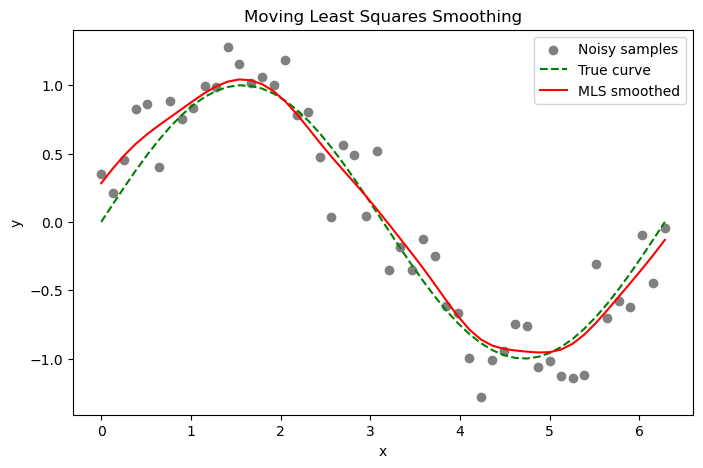

In [100]:
# 4. Apply smoothing
h = 0.5
f_smooth = mls_smooth(x, f_noisy, h)

# 5. Plot results
plt.figure(figsize=(8,5))
plt.scatter(x, f_noisy, color='gray', label='Noisy samples')
plt.plot(x, f_true, 'g--', label='True curve')
plt.plot(x, f_smooth, 'r', label='MLS smoothed')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Moving Least Squares Smoothing")
plt.show()
